In [2]:
# general tools
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# deep learning tools
import tensorflow as tf
from tensorflow import keras

from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
from keras_unet_collection import layer_utils as k_layers
from keras_unet_collection.activations import GELU

In [4]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu

from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

def verif_metric(VALID_target, Y_pred, thres=0.5):

    tn, fp, fn, tp = confusion_matrix(VALID_target.ravel(), Y_pred.ravel()>thres).ravel()

    CSI = tp/(tp+fn+fp)
    CSI_metric = 1 - CSI
    
    POFD = fp/(tn+fp)
    
    fpr, tpr, thresholds = roc_curve(VALID_target.ravel(), Y_pred.ravel())
    AUC = auc(fpr, tpr)
    AUC_metric = 1 - AUC
    
    freq = (tp+fp)/(tp+fn)
    freq_metric = np.abs(freq-1.0)
    
    print('{} {} {} {}'.format(CSI, POFD, AUC, freq))
    metric = 0.3*CSI_metric + 0.7*freq_metric


    return metric

In [5]:
L_vars = 19

In [6]:
filename_neg_storm = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*storm*.npy"))
filename_neg_calm = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*calm*.npy"))
filename_neg_wind = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*wind*.npy"))
filename_neg_hail = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*hail*.npy"))
filename_aug = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_aug/*.npy"))

In [7]:
with h5py.File(save_dir_scratch+'VALID_real_lead{}.hdf'.format(21), 'r') as h5io:
    TEST_input = h5io['TEST_input'][...]
    TEST_target = h5io['TEST_target'][...]
    
TEST_target[np.isnan(TEST_target)] = 0.0
TEST_target[TEST_target!=0] = 1.0

TEST_input = TEST_input[:5000, ...]
TEST_target = TEST_target[:5000, ...]

In [8]:
IN = tf.keras.Input((128, 128, 19))

X = IN

X = k_layers.CONV_stack(X, 32, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack1')
X = tf.keras.layers.Conv2D(32, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv1')(X)

X = k_layers.CONV_stack(X, 64, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack2')
X = tf.keras.layers.Conv2D(64, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv2')(X)

X = k_layers.CONV_stack(X, 128, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack3')
X = tf.keras.layers.Conv2D(128, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv3')(X)

X = k_layers.CONV_stack(X, 256, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack4')
X = tf.keras.layers.Conv2D(256, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv4')(X)

X = k_layers.CONV_stack(X, 512, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack5')
X = tf.keras.layers.Conv2D(512, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv5')(X)

D = tf.keras.layers.Flatten()(X)

D = tf.keras.layers.Dense(512, use_bias=False, name='dense1')(D)
D = tf.keras.layers.BatchNormalization(axis=-1, name='dense_bn1')(D)
D = GELU()(D)

D = tf.keras.layers.Dense(128, use_bias=False, name='dense2')(D)
D = tf.keras.layers.BatchNormalization(axis=-1, name='dense_bn2')(D)
D = GELU()(D)

D = tf.keras.layers.Dense(1, activation='sigmoid', name='head')(D)
#D = tf.keras.layers.Softmax()(D)

OUT = D

2022-08-27 12:18:50.952605: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-27 12:18:52.215447: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-27 12:18:52.326565: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:b2:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-27 12:18:52.327516: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-27 12:18:52.539507: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-27 12:18:52.541361: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

In [9]:
model = keras.models.Model(inputs=[IN,], outputs=[OUT,])

In [10]:
tol = 0
min_del = 0
max_tol = 500 # early stopping with patience

epochs = 500
L_train = 64
batch_size = 100

batch_size_half = 50

valid_size = 1

In [32]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'VGG_tornado'

model_name = '{}_pp20'.format(key)
model_path = temp_dir+model_name

W_new = model.get_weights()
W_old = k_utils.dummy_loader(temp_dir+'VGG_X_pp20_tune2')

for l in range(len(W_old)):
    if W_old[l].shape == W_new[l].shape:
        W_new[l] = W_old[l]
        
model.set_weights(W_new)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=2e-5))

In [19]:
# X_batch_sparse = np.empty((batch_size, 128, 128, L_sparse))*np.nan
# X_batch_dense = np.empty((batch_size, 128, 128, L_dense))*np.nan
X_batch = np.empty((batch_size, 128, 128, L_vars))
Y_batch = np.empty((batch_size, 1))
X_batch[...] = np.nan
Y_batch[...] = np.nan

In [56]:
#Y_pred = model.predict([VALID_X])
record = 999 #np.nanmean(np.abs(Y_pred-VALID_Y))
print("Initial record: {}".format(record))

Initial record: 999


In [17]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:
from sklearn.metrics import classification_report, auc, roc_curve

In [61]:
X_batch.shape

(100, 128, 128, 19)

In [63]:
# ========== Training loop ========== #

N_aug = 15
N_wind = 15
N_hail = 10
N_storm = 30
N_calm = 30

L_storm = len(filename_neg_storm)
L_calm = len(filename_neg_calm)
L_wind = len(filename_neg_wind)
L_hail = len(filename_neg_hail)
L_aug = len(filename_aug)

for i in range(epochs):
    
    if i <= 10:
        batch_size_full = 70
    if i > 10 and i <= 35:
        batch_size_full = 85
    if i > 35:
        batch_size_full = 95
    
    batch_size_aug = batch_size - batch_size_full
    
    #print('epoch = {}'.format(i))
    start_time = time.time()
    
    # loop of batch
    for j in range(L_train):
        
        ind_storm = du.shuffle_ind(L_storm)
        ind_calm = du.shuffle_ind(L_calm)
        ind_wind = du.shuffle_ind(L_wind)
        ind_hail = du.shuffle_ind(L_hail)
        ind_aug = du.shuffle_ind(L_aug)
        
        file_pick_storm = []
        for ind_temp in ind_storm[:N_storm]:
            file_pick_storm.append(filename_neg_storm[ind_temp])
            
        file_pick_calm = []
        for ind_temp in ind_calm[:N_calm]:
            file_pick_calm.append(filename_neg_calm[ind_temp])
            
        file_pick_wind = []
        for ind_temp in ind_wind[:N_wind]:
            file_pick_wind.append(filename_neg_wind[ind_temp])
            
        file_pick_hail = []
        for ind_temp in ind_hail[:N_hail]:
            file_pick_hail.append(filename_neg_hail[ind_temp])

        file_pick_aug = []
        for ind_temp in ind_aug[:N_aug]:
            file_pick_aug.append(filename_aug[ind_temp])
        
        file_pick = file_pick_storm + file_pick_calm + file_pick_wind + file_pick_hail + file_pick_aug
        
        if len(file_pick) != 100:
            sregwet
        
        for k in range(batch_size):
            
            data = np.load(file_pick[k])
            #for c, v in enumerate(ind_pick_from_batch):
            X_batch[k, ...] = data
            
            if 'pos' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.95, 0.99)
            elif 'neg' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.01, 0.05)
            else:
                werhgaer
        
        # # add noise within sparse inputs
        # for v in flag_sparse:
        #     X_batch[..., v] += np.random.uniform(0, 0.01, size=(batch_size, 128, 128))

        # shuffle indices
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([TEST_input,])
    record_temp = verif_metric(TEST_target, Y_pred, thres=0.5)
    
    # if i % 10 == 0:
    #     model.save(model_path_backup)
    
    if (record - record_temp > min_del) and (np.max(Y_pred) > 0.6):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))

0.016917293233082706 0.10478861951512723 0.9798971482000935 59.111111111111114
Validation loss improved from 49.263458110516936 to 40.97270258980785
save to: /glade/work/ksha/NCAR/Keras_models/VGG_tornado_pp20
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/VGG_tornado_pp20/assets
--- 350.8166353702545 seconds ---
0.013435700575815739 0.1025846523742737 0.94905273937532 57.666666666666664
Validation loss improved from 40.97270258980785 to 39.96263595649392
save to: /glade/work/ksha/NCAR/Keras_models/VGG_tornado_pp20
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/VGG_tornado_pp20/assets
--- 352.8719947338104 seconds ---
0.0136986301369863 0.08595471849328792 0.9379549856408201 48.333333333333336
Validation loss improved from 39.96263595649392 to 33.42922374429224
save to: /glade/work/ksha/NCAR/Keras_models/VGG_tornado_pp20
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/VGG_tornado_pp20/assets
--- 349.0566303730011 secon

KeyboardInterrupt: 

In [12]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

W_old = k_utils.dummy_loader(temp_dir+'VGG_tornado_pp20')
model.set_weights(W_old)

In [13]:
Y_pred = model.predict([TEST_input,])
record_temp = verif_metric(TEST_target, Y_pred, thres=0.5)

2022-08-27 12:22:18.421824: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-27 12:22:18.520717: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz
2022-08-27 12:22:21.149389: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-27 12:22:22.303724: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


0.015625 0.011019835704267681 0.9446114116520848 6.222222222222222


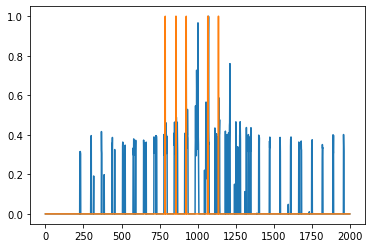

In [15]:
plt.plot(Y_pred[2500:4500])
plt.plot(TEST_target[2500:4500])

In [21]:
key = 'VGG_tornado'

model_name = '{}_pp20_tune'.format(key)
model_path = temp_dir+model_name

model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.Adam(lr=5e-5))

In [22]:
record = verif_metric(TEST_target, Y_pred, thres=0.5)
print("Initial record: {}".format(record))

0.009615384615384616 0.019034261671007816 0.9331908546494802 10.666666666666666
Initial record: 7.06378205128205


In [ ]:
# ========== Training loop ========== #

N_aug = int(np.random.uniform(10, 15))
N_wind = int(np.random.uniform(10, 15))
N_hail = int(np.random.uniform(7, 13))
N_storm = int(np.random.uniform(25, 35))
N_calm = 100 - N_aug - N_wind - N_hail - N_storm

L_storm = len(filename_neg_storm)
L_calm = len(filename_neg_calm)
L_wind = len(filename_neg_wind)
L_hail = len(filename_neg_hail)
L_aug = len(filename_aug)

for i in range(epochs):
    
    if i <= 10:
        batch_size_full = 70
    if i > 10 and i <= 35:
        batch_size_full = 85
    if i > 35:
        batch_size_full = 95
    
    batch_size_aug = batch_size - batch_size_full
    
    #print('epoch = {}'.format(i))
    start_time = time.time()
    
    # loop of batch
    for j in range(L_train):
        
        ind_storm = du.shuffle_ind(L_storm)
        ind_calm = du.shuffle_ind(L_calm)
        ind_wind = du.shuffle_ind(L_wind)
        ind_hail = du.shuffle_ind(L_hail)
        ind_aug = du.shuffle_ind(L_aug)
        
        file_pick_storm = []
        for ind_temp in ind_storm[:N_storm]:
            file_pick_storm.append(filename_neg_storm[ind_temp])
            
        file_pick_calm = []
        for ind_temp in ind_calm[:N_calm]:
            file_pick_calm.append(filename_neg_calm[ind_temp])
            
        file_pick_wind = []
        for ind_temp in ind_wind[:N_wind]:
            file_pick_wind.append(filename_neg_wind[ind_temp])
            
        file_pick_hail = []
        for ind_temp in ind_hail[:N_hail]:
            file_pick_hail.append(filename_neg_hail[ind_temp])

        file_pick_aug = []
        for ind_temp in ind_aug[:N_aug]:
            file_pick_aug.append(filename_aug[ind_temp])
        
        file_pick = file_pick_storm + file_pick_calm + file_pick_wind + file_pick_hail + file_pick_aug
        
        if len(file_pick) != 100:
            sregwet
        
        for k in range(batch_size):
            
            data = np.load(file_pick[k])
            #for c, v in enumerate(ind_pick_from_batch):
            X_batch[k, ...] = data
            
            if 'pos' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.95, 0.99)
            elif 'neg' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.01, 0.05)
            else:
                werhgaer
        
        # # add noise within sparse inputs
        # for v in flag_sparse:
        #     X_batch[..., v] += np.random.uniform(0, 0.01, size=(batch_size, 128, 128))

        # shuffle indices
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([TEST_input,])
    record_temp = verif_metric(TEST_target, Y_pred, thres=0.5)
    
    # if i % 10 == 0:
    #     model.save(model_path_backup)
    
    if (record - record_temp > min_del) and (np.max(Y_pred) > 0.6):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))

0.01607142857142857 0.11039871769184532 0.9598276898417151 62.22222222222222
Validation loss 43.150734126984126 NOT improved
0.014925373134328358 0.11901422560609097 0.9662169683207551 67.0
Validation loss 46.4955223880597 NOT improved


In [31]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'TH_chad'
model_name = '{}_pp20'.format(key)
model_path = temp_dir+model_name

W = k_utils.dummy_loader(model_path)
model.set_weights(W)

model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.Adam(lr=2.5e-6))

model_name = '{}_pp20_tune'.format(key)
model_path = temp_dir+model_name

In [32]:
#Y_pred = model.predict([VALID_dense, VALID_sparse])

fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
record_temp = auc(fpr, tpr)
record_temp = 1 - record_temp

print(record_temp)

0.10375657098555346


In [33]:
auc(fpr, tpr)

0.8962434290144465

In [34]:
VALID_label.ravel()

array([1., 1., 1., ..., 0., 0., 0.])

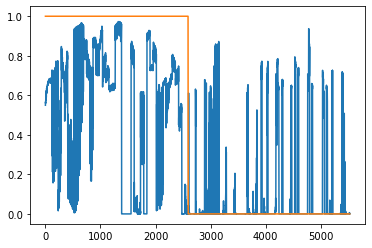

In [35]:
plt.plot(Y_pred.ravel())
plt.plot(VALID_label.ravel())

In [ ]:
# ------------------- #
# loop of epoch
#filenames = glob(batch_dir+'TRAIN*.npy')

for i in range(epochs):
    #print('epoch = {}'.format(i))
    start_time = time.time()
    shuffle(filename_train_pos)
    shuffle(filename_train_neg)
    
    # loop of batch
    for j in range(L_train):
        
        shuffle(filename_train_pos)
        shuffle(filename_train_neg)
        
        file_pick_pos = filename_train_pos[:batch_size_half]
        file_pick_neg = filename_train_neg[:batch_size_half]
        
        file_pick = file_pick_pos+file_pick_neg
        
        # for k in range(batch_size):
        #     data = np.load(file_pick[k])
        #     X_batch[k, ...] = data[...]
        
        for k in range(batch_size):
            data = np.load(file_pick[k])
            count0 = 0
            count1 = 0
            X_batch[k, ...] = data
            for v in range(L_vars):
                if v in flag_sparse:
                    X_batch_sparse[k, ..., count0] = data[..., v]
                    count0 += 1
                else:
                    X_batch_dense[k, ..., count1] = data[..., v]
                    count1 += 1
        
        #X_batch = X_batch_dense
        
        Y_batch = np.ones((batch_size, 1))*0.9
        Y_batch[batch_size_half:, :] = 0.1
        
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([VALID_input])
    
    fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
    record_temp = auc(fpr, tpr)
    record_temp = 1 - record_temp
    
    if record - record_temp > min_del:
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))

Validation loss 0.1043951541739152 NOT improved
Validation loss 0.12166224398894021 NOT improved
Validation loss 0.1341117928968224 NOT improved
Validation loss 0.1460073252569566 NOT improved
Validation loss 0.1651520833858593 NOT improved
Validation loss 0.185732504685307 NOT improved
Validation loss 0.2073937769457681 NOT improved
Validation loss 0.2145583704165932 NOT improved
Validation loss 0.261279403978519 NOT improved
Validation loss 0.22646394834816663 NOT improved
Validation loss 0.25116883178276983 NOT improved
Validation loss 0.2453876382480733 NOT improved
Validation loss 0.2616122866399415 NOT improved
Validation loss 0.2609196018119322 NOT improved
Validation loss 0.2574970165309398 NOT improved
Validation loss 0.2652126719696779 NOT improved
Validation loss 0.2625383832749246 NOT improved
Validation loss 0.25101795123919013 NOT improved
Validation loss 0.26022849275983484 NOT improved
Validation loss 0.2515193106085436 NOT improved
Validation loss 0.2586230397347653 NO

In [50]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'TH_chad'
model_name = '{}_pp20'.format(key)
model_path = temp_dir+model_name

W = k_utils.dummy_loader(model_path)
model.set_weights(W)

### Classification results

In [9]:
from sklearn.metrics import classification_report, auc, roc_curve

In [53]:
#filename_train_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*TRAIN*.npy"))
#filename_train_neg = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*TRAIN*.npy"))

filename_valid_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*VALID*.npy"))
filename_valid_neg = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*VALID*.npy"))

In [54]:
grid_shape = (128, 128)

label_pos = np.ones(len(filename_valid_pos))
label_neg = np.zeros(len(filename_valid_neg))
VALID_label = np.hstack([label_pos, label_neg])

L_valid = len(VALID_label)
L_vars = 20
L_sparse = len(flag_sparse)
L_dense = L_vars - L_sparse

VALID_sparse = np.empty((L_valid,)+grid_shape+(L_sparse,))
VALID_dense = np.empty((L_valid,)+grid_shape+(L_dense,))

for i, filename in enumerate(filename_valid_pos+filename_valid_neg):
    data = np.load(filename)
    count0 = 0
    count1 = 0
    for v in range(L_vars):
        if v in flag_sparse:
            VALID_sparse[i, ..., count0] = data[..., v]
            count0 += 1
        else:
            VALID_dense[i, ..., count1] = data[..., v]
            count1 += 1

In [60]:
VALID_label

array([1., 1., 1., ..., 0., 0., 0.])

In [55]:
# filename_valid_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*VALID*.npy"))[::10]
# label_pos = np.ones(len(filename_valid_pos))
# label_neg = np.zeros(len(filename_valid_neg))
# VALID_label_skew = np.hstack([label_pos, label_neg])

# L_valid = len(VALID_label_skew)

# VALID_skew = np.empty((L_valid,)+grid_shape+(5,))

# for i, filename in enumerate(filename_valid_pos+filename_valid_neg):
#     data = np.load(filename)
#     VALID_skew[i, ...] = data[...]

**Balanced verif**

In [56]:
Y_pred = model.predict([VALID_dense, VALID_sparse])
Y_pred_label = Y_pred > 0.5

2022-08-11 17:58:34.004253: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 47110422528 exceeds 10% of free system memory.


In [57]:
print(classification_report(Y_pred_label.ravel(), VALID_label.ravel()))

              precision    recall  f1-score   support

         0.0       1.00      0.53      0.69     55296
         1.0       0.00      0.00      0.00         0

    accuracy                           0.53     55296
   macro avg       0.50      0.27      0.35     55296
weighted avg       1.00      0.53      0.69     55296



/glade/work/ksha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/glade/work/ksha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/glade/work/ksha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
print(classification_report(Y_pred_label.ravel(), VALID_label.ravel()))

              precision    recall  f1-score   support

       False       0.88      0.78      0.83     33142
        True       0.72      0.84      0.77     22154

    accuracy                           0.80     55296
   macro avg       0.80      0.81      0.80     55296
weighted avg       0.81      0.80      0.80     55296



In [58]:
fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
auc(fpr, tpr)

0.9319409017491813

In [17]:
fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
auc(fpr, tpr)

0.8871815021742365

In [18]:
fpr.shape

(17970,)

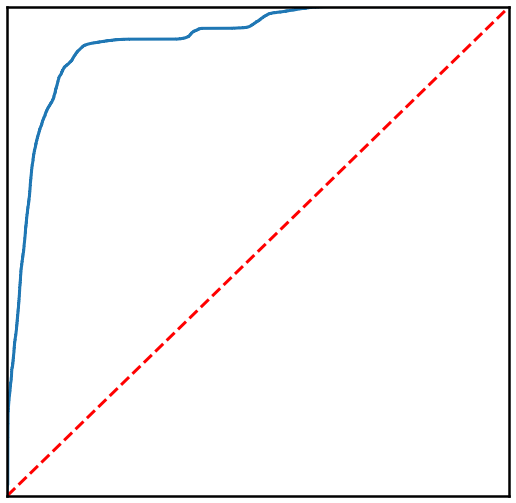

In [61]:
fig = plt.figure(figsize=(9, 9))
ax = fig.gca()
ax = gu.ax_decorate_box(ax)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.plot(fpr, tpr, lw=3)
ax.plot(fpr, fpr, 'r--', lw=3)

**Natural verif**

In [25]:
Y_pred = model.predict([VALID_skew])
Y_pred_label = Y_pred > 0.5
print(classification_report(Y_pred_label.ravel(), VALID_label_skew.ravel()))

              precision    recall  f1-score   support

       False       0.88      0.97      0.92     26640
        True       0.67      0.33      0.44      5328

    accuracy                           0.86     31968
   macro avg       0.78      0.65      0.68     31968
weighted avg       0.84      0.86      0.84     31968



In [26]:
fpr, tpr, thresholds = roc_curve(VALID_label_skew.ravel(), Y_pred.ravel())
auc(fpr, tpr)

0.8685229089653266

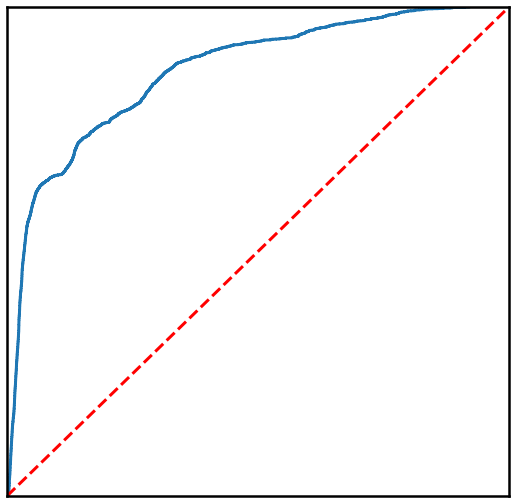

In [27]:
fig = plt.figure(figsize=(9, 9))
ax = fig.gca()
ax = gu.ax_decorate_box(ax)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.plot(fpr, tpr, lw=3)
ax.plot(fpr, fpr, 'r--', lw=3)

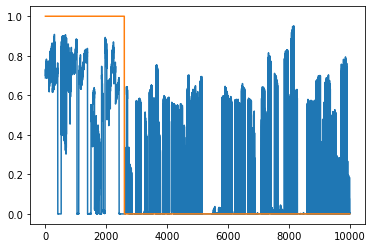

In [40]:
plt.plot(Y_pred.ravel()[:10000])
plt.plot(VALID_label_skew.ravel()[:10000])

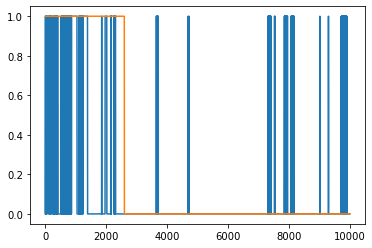

In [42]:
plt.plot(Y_pred.ravel()[:10000]>0.7)
plt.plot(VALID_label_skew.ravel()[:10000])